In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
%matplotlib inline

Objects to make conversion between coordinate systems easier.

In [2]:
class CartesianCoords(object):
    
    def __init__(self, x, y, z=0):
        self.x = x
        self.y = y
        self.z = z
        self.r = math.sqrt(x**2 + y**2 + z**2)  #radial
        self.a = np.arctan2(x, y)    #azimuth
        self.h = z #cylindrical height

class PolarCoords(object):
    
    def __init__(self, radial, azimuth, height=0):
        self.r = radial
        self.a = azimuth
        self.h = height
        self.x = radial*np.cos(azimuth)
        self.y = radial*np.sin(azimuth)
        self.z = height

Testing to see how well the area of a circle is represented as the diameter of the circle increases, for fixed element size (1$\times$1 nm).

In [3]:
diam_range = 125 #maximum diameter to be tested
efficiency = np.zeros(diam_range)
error = np.zeros(diam_range)

Create a square matrix of zeros and populate with 1's if lying within the circle boundary.

In [4]:
for d in range(diam_range):
    x_spacing, y_spacing = 1., 1.
    xs = np.linspace(-0.5*d,0.5*d,(d/x_spacing)+1)
    ys = np.linspace(-0.5*d,0.5*d,(d/y_spacing)+1)

    Z = np.zeros((len(xs), len(ys)))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            if CartesianCoords(x,y).r <= 0.5*d:
                Z[i][j] = 1
    efficiency[d] = (np.count_nonzero(Z)/(float(len(xs))*float(len(ys))))/(0.25*np.pi)

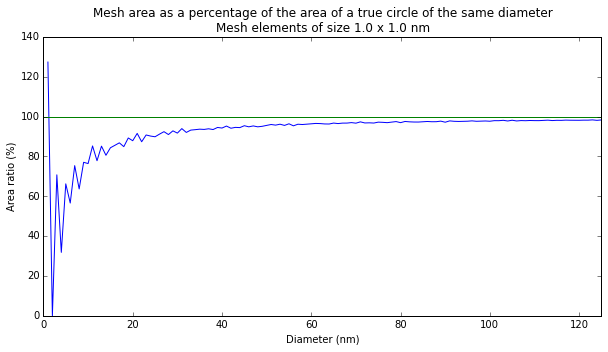

In [5]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.plot(range(1,diam_range+1), efficiency*100); ax.plot([0,diam_range],[100,100], 'g')
ax.set_xlim(0,diam_range); #ax.set_ylim(0,100)
ax.set_ylabel("Area ratio (%)"); ax.set_xlabel("Diameter (nm)")
ax.set_title("Mesh area as a percentage of the area of a true circle of the same diameter\nMesh elements of size {} x {} nm"
             .format(x_spacing, y_spacing));

This tends towards 100%, but for all systems (apart from one small, anomalous system) the area for the circle comprising of square elements is an underestimation.

#Mesh element demonstration

Testing interchangeability of coordinate systems using objects.

In [7]:
c = CartesianCoords(6.0,6.0)
d = PolarCoords(c.r, c.a)
print(d.x, d.y)

6.0 6.0


In [19]:
def plot_circular_fidi_mesh(diameter, x_spacing, y_spacing, centre_mesh='auto',
                            show_axes=True, show_title=True):
    """
    Plots a representation of a circular mesh of specified diameter 
    comprised of rectangular elements of size x_spacing x y_spacing nm.
    
    
    Requires the following imports:
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    
    Miscellaneous info:
    ~~~~~~~~~~~~~~~~~~~
    
    centre_mesh = True    This will set the middle of the mesh to lie at the centre of an element.
    centre_mesh = False     "    "   "   "     "    "  "    "   "  "   "  "  corner  "  "    "   .
    centre_mesh = 'auto'  The centering will be decided based on whichever will fit the geometry best.
    
    
    Known bugs:
    ~~~~~~~~~~~
    
    When the diameter/x_spacing or y_spacing does not produce an integer, the mesh will not be centered correctly.
    It is recommended that centre_mesh be set to True in this case.
    """
    
    #initial setup of figure
    fig = plt.figure(figsize = (diameter**0.45,diameter**0.45))
    ax0 = fig.add_subplot(111)
    
    ax0.set_xlim(-0.5*diameter, 0.5*diameter)
    ax0.set_ylim(-0.5*diameter, 0.5*diameter)
    
    if show_axes == True:
        ax0.set_xlabel("Radius (nm)"); ax0.set_ylabel("Radius (nm)")
    else:
        ax0.get_yaxis().set_visible(False)
        ax0.get_xaxis().set_visible(False)
        ax0.set_frame_on(False)
    
    #plotting reference circle
    ax0.add_patch(plt.Circle((0,0), radius = 0.5*diameter, alpha = 0.25))
    
    #decide if centering will cause asymmetry
    if centre_mesh == 'auto':
        if diameter%(2*x_spacing) == 0 and diameter%(2*y_spacing) == 0:
            centre_mesh = False
        else:
            centre_mesh = True
    
    area = 0
    unit_area = x_spacing*y_spacing
    
    if centre_mesh == True:
        #produces lists of the form [0,2,-2,4,-4,6,-6,8,-8,10,-10]
        #(spacing = 2; diameter = 20, in this example)
        #trailing slice index is to remove leading zero which would cause duplicate patches
        xlist = sorted(list(range(0, (diameter/2)+1, x_spacing)) 
                       + list(range(0,-(diameter/2)-1,-x_spacing)), 
                       key=abs)[1:]
        ylist = sorted(list(range(0, (diameter/2)+1, y_spacing)) 
                       + list(range(0,-(diameter/2)-1,-y_spacing)), 
                       key=abs)[1:]
    
        for y in ylist:
            for x in xlist:
                box_coord = (x - 0.5*x_spacing, y - 0.5*y_spacing)
                if CartesianCoords(x,y).r <= 0.5*diameter:
                    #plot rectangle
                    ax0.add_patch(patches.Rectangle(box_coord, x_spacing, y_spacing, alpha = 0.25))
                    area += unit_area
                else:
                    break #if circle boundary exceeded once, no point proceeding with this row
    elif centre_mesh == False:
        xmax = int((diameter/2.)+(diameter%x_spacing))
        ymax = int((diameter/2.)+(diameter%y_spacing))
        xlist = range(-xmax,xmax,x_spacing)
        ylist = range(-ymax,ymax,y_spacing)
        for y in ylist:
            for x in xlist:
                centre_coord = (x + 0.5*x_spacing, y + 0.5*y_spacing)
                if (CartesianCoords(centre_coord[0], centre_coord[1]).r <= 0.5*diameter):
                    #plot element
                    ax0.add_patch(patches.Rectangle((x,y), x_spacing, y_spacing, alpha = 0.25))
                    area += unit_area
                else:
                    pass 
    else:
        raise ValueError("Unrecognised value for centre_mesh! Please choose True, False or 'auto'.")
    
    elem_count = area/(x_spacing*y_spacing)
    
    if show_title == True:
        ax0.set_title("Finite difference mesh demonstration\n\
        Diameter = {} nm\n{} elements of size {}x{} nm"
                      .format(diameter, elem_count, x_spacing, y_spacing))
    #return area

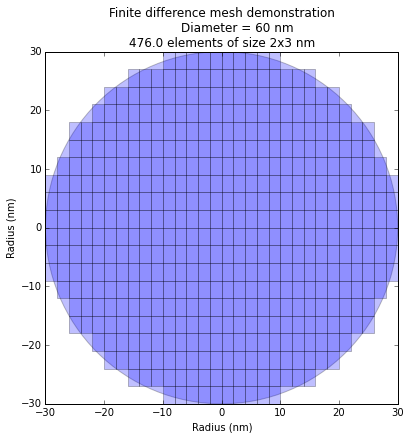

In [20]:
plot_circular_fidi_mesh(diameter=60,x_spacing=2,y_spacing=3, centre_mesh=False)

Function to determine if a point lies within a regular polygon, which can also be rotated and translated.
Uses a summing angle method found on [WolframAlpha Demonstrations](http://demonstrations.wolfram.com/IsAPointInsideOrOutsideARegularPolygon/).

To be used for creating polygons for fidimag or plotting the mesh in the function defined shortly.

In [28]:
def in_poly(x, y, n, r=1, rotation=0, translate=(0,0), plot=False):
    """
    Determines whether or not the point (x,y) lies within a regular n-sided
    polygon whose circumscribing circle has radius r.
    
    By default, a point will lie at the Cartesian location (r, 0) but can
    be rotated (anti-clockwise) by specifying a rotation (in radians).
    
    Polygon centred at (0,0) by default, but this can be changed by giving
    translate as an (x,y) tuple.
    """
    
    def poly_coords(r, n, rotation=rotation, translate=translate):
        coords = np.empty((n,2))
        for i in range(n):
            coord = PolarCoords(r, (2.*np.pi*i/n)+rotation)
            coords[i][0], coords[i][1] = coord.x+translate[0], coord.y+translate[1]
        return coords
    
    def angle_test(x, y, r=r, n=n, rotation=rotation):
        """
        Taking all pairs of adjacent vertices of the polygon, the sum of
        the angles made by each pair of points about the point in question
        should be approximately 2*pi.
        """
        np.seterr(all='raise')
        
        coords = poly_coords(r,n,rotation,translate)
        coord1 = [x,y]
        angle = 0
        for i in range(len(coords)):
            try:
                coord2 = coords[i]
                coord3 = coords[i+1]
            except IndexError:
                coord3 = coords[0]
            #cosine rule to determine angle
            length12 = math.sqrt((coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2)
            length13 = math.sqrt((coord1[0]-coord3[0])**2 + (coord1[1]-coord3[1])**2)
            length23 = math.sqrt((coord2[0]-coord3[0])**2 + (coord2[1]-coord3[1])**2)
            #if np.isclose([coord2[0], coord3[0]], coord1[0]).any():
            #    continue
            #elif np.isclose([coord2[1], coord3[1]], coord1[1]).any():
            #    continue
            #else:
            try:
                angle += np.arccos((length12**2 + length13**2 - length23**2)/(2*length12*length13))
            except (FloatingPointError,ZeroDivisionError): #for points on the boundary
                angle = 2*np.pi
                #pass
                break
        return angle
    if plot == True:
        coords = poly_coords(r,n,rotation,translate)
        fig = plt.figure()
        ax0 = fig.add_subplot(111)
        ax0.set_xlim(-r+translate[0],r+translate[0])
        ax0.set_ylim(-r+translate[1],r+translate[1])
        ax0.set_aspect('equal')
        ax0.plot(np.transpose(np.concatenate((coords, coords),axis=0)[:n+1],
                              (1,0))[0],np.transpose(np.concatenate((coords, coords),axis=0)[:n+1], (1,0))[1])
        if np.isclose(2*np.pi, angle_test(x,y), atol=1e-4):
            dotcolour = 'g'
        else:
            dotcolour = 'r'
        ax0.scatter([x,0+translate[0]],[y,0+translate[1]], c=[dotcolour,'b'], s=[20,10],lw = 0)
    return np.isclose(2*np.pi, angle_test(x,y), atol=1e-4)

Demonstration of the `in_poly` function. Returns True or False

True
False


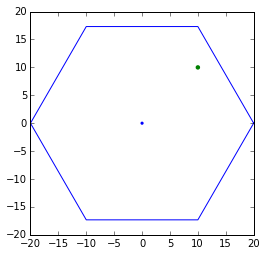

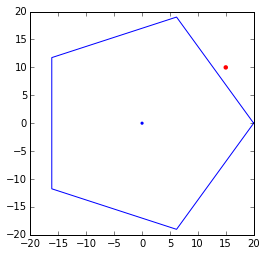

In [29]:
print(in_poly(x=10,y=10,n=6,r=20,plot=True))
print(in_poly(x=15,y=10,n=5,r=20,plot=True))

In [34]:
def plot_poly_fidi_mesh(diameter,n,x_spacing,y_spacing,rotation=0,translate=(0,0),
                        centre_mesh='auto',show_axes=True, show_title=True):
    """
    Plots a representation of an n-sided polygon mesh with a containing circle
    of specified diameter, comprised of rectangular elements of size 
    x_spacing*y_spacing (in nanometres).
    
    
    Requires the following imports:
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    
    Miscellaneous info:
    ~~~~~~~~~~~~~~~~~~~
    
    centre_mesh = True    will set the middle of the mesh to lie at the centre of an element.
    centre_mesh = False     "   "   "     "    "  "    "   "  "   "  "  corner  "  "    "   .
    centre_mesh = 'auto'  will decide True or False based on whichever will best fit the geometry.
    
    The radius is defined as the circumradius, i.e., the distance from the circumcentre
    of the shape to one of its vertices.
    For example, to get a square with edge length 50, diameter must be given as 50*(2**0.5).
    
    
    Known bugs:
    ~~~~~~~~~~~
    Using find_circumradius to give exact side lengths can produce unusual
    tails trailing off some corners.
    """
    
    #initial setup of figure
    fig = plt.figure(figsize = (diameter**0.45,diameter**0.45))
    ax0 = fig.add_subplot(111)
    
    ax0.set_xlim(-0.5*diameter+translate[0], 0.5*diameter+translate[0])
    ax0.set_ylim(-0.5*diameter+translate[1], 0.5*diameter+translate[1])
    
    if show_axes == True:
        ax0.set_xlabel("x (nm)"); ax0.set_ylabel("y (nm)")
    else:
        ax0.get_yaxis().set_visible(False)
        ax0.get_xaxis().set_visible(False)
        ax0.set_frame_on(False)    
    
    #decide if centering will prevent asymmetry
    #maybe incorporate independent centering for x and y
    #(tried this and it was extremely difficult...)
    if centre_mesh == 'auto':
        if diameter%(2*x_spacing) == 0 and diameter%(2*y_spacing) == 0:
            centre_mesh = False
        else:
            centre_mesh = True
    
    area = 0
    unit_area = x_spacing*y_spacing
    
    if centre_mesh == True:
        #produces lists of the form [0,2,-2,4,-4,6,-6,8,-8,10,-10]
        #(spacing = 2; diameter = 20, in this example)
        #trailing slice index is to remove leading zero which would cause duplicate patches
        xlist = sorted(list(range(0, int(diameter/2)+1, x_spacing)) 
                       + list(range(0,-int(diameter/2)-1,-x_spacing)), key=abs)[1:]
        xlist = [x + translate[0] for x in xlist[:]]
        ylist = sorted(list(range(0, int(diameter/2)+1, y_spacing)) 
                      + list(range(0,-int(diameter/2)-1,-y_spacing)), key=abs)[1:]
        ylist = [y + translate[1] for y in ylist[:]]
    
        for y in ylist:
            for x in xlist:
                box_coord = (x - 0.5*x_spacing, y - 0.5*y_spacing)
                if in_poly(x, y, n=n, r=diameter/2.,
                           rotation=rotation, translate=translate, plot=False):
                    #plot element
                    ax0.add_patch(patches.Rectangle(box_coord, x_spacing, y_spacing, alpha = 0.25))
                    area += unit_area
                else:
                    pass
                
    elif centre_mesh == False:
        xmax = int((diameter/2.)+(diameter%x_spacing))
        ymax = int((diameter/2.)+(diameter%y_spacing))
        xlist = [x + translate[0] for x in range(-xmax,xmax,x_spacing)]
        ylist = [y + translate[1] for y in range(-ymax,ymax,y_spacing)]
        
        for y in ylist:
            for x in xlist:
                centre_coord = (x + 0.5*x_spacing, y + 0.5*y_spacing)
                if in_poly(centre_coord[0], centre_coord[1], n=n, r=diameter/2.,
                           rotation=rotation, translate=translate):
                    ax0.add_patch(patches.Rectangle((x,y), x_spacing, y_spacing, alpha = 0.25))
                    area += unit_area
                else:
                    pass        
    else:
        raise ValueError("Unrecognised value \"{}\" for centre_mesh! Please choose True, False or 'auto'."
                         .format(centre_mesh))
    
    #plot reference polygon
    coords = np.empty((n,2))
    for i in range(n):
        coord = PolarCoords(diameter/2., (2.*np.pi*i/n)+rotation)
        coords[i][0], coords[i][1] = coord.x+translate[0], coord.y+translate[1]
    ax0.plot(np.transpose(np.concatenate((coords, coords),axis=0)[:n+1],
                          (1,0))[0],np.transpose(np.concatenate((coords, coords),axis=0)[:n+1], (1,0))[1])
    elem_count = area/(x_spacing*y_spacing)
    
    if show_title == True:
        ax0.set_title("Finite difference mesh demonstration\nDiameter = {:.2f} nm\n{} elements of size {}x{} nm"
                      .format(diameter, elem_count, x_spacing, y_spacing))
    #return area

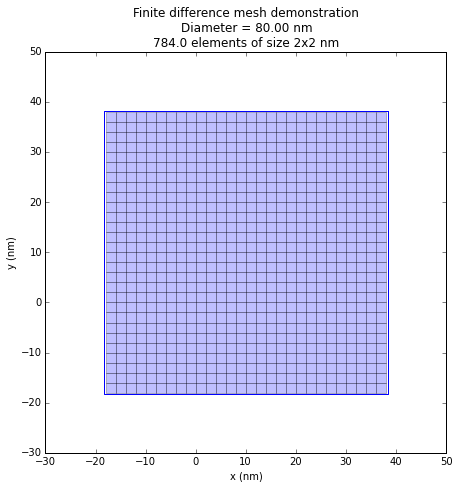

In [35]:
plot_poly_fidi_mesh(diameter=80,n=4,x_spacing=2,y_spacing=2, centre_mesh=False, rotation = np.pi/4, translate = (10,10))

Following function, `find_circumradius` can be used in conjunction with above functions when another dimension needs to be specified.

In [36]:
def find_circumradius(n, side = 0, apothem = 0):
    """
    Returns the radius of the circumscribing circle for a regular polygon
    given the side length or the apothem (distance from circumcentre to 
    centre of a face).
    """
    if side == 0 and apothem != 0:
        circumradius = apothem/(np.cos(np.pi/n))
    elif side != 0 and apothem == 0:
        circumradius = side/(2*np.sin(np.pi/n))
    elif side == 0 and apothem == 0:
        raise ValueError("Please specify a side length or an apothem.")
    else:
        raise ValueError("Please specify side length OR apothem, not both!")
    return circumradius
        

For example, if I want to plot a hexagon with an apothem of 50 nm, what value of the radius should I input?

In [37]:
find_circumradius(6, apothem=50)

57.735026918962575

Using `find_circumradius` in the input can give the correctly sized mesh, although there are still some bugs with this feature, these are caused by a combination of an exception being triggered accidentally and floating-point inaccuracies.

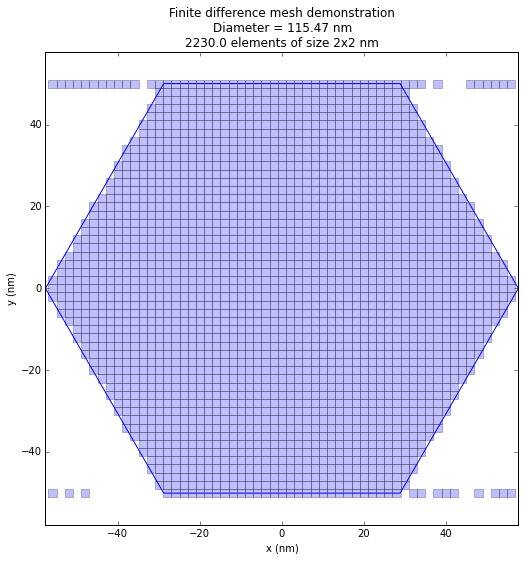

In [38]:
plot_poly_fidi_mesh(diameter=2*find_circumradius(6,apothem=50),n=6,x_spacing=2,y_spacing=2)

An attempt to fix this slowed down the code noticeably, but rounding the output to `find_circumradius` seems to have fixed the problem at the expense of negligible error.

In [39]:
def find_circumradius(n, side = 0, apothem = 0):
    """
    Returns the radius of the circumscribing circle for a regular polygon
    given the side length or the apothem (distance from circumcentre to 
    centre of a face).
    """
    if side == 0 and apothem != 0:
        circumradius = apothem/(np.cos(np.pi/n))
    elif side != 0 and apothem == 0:
        circumradius = side/(2*np.sin(np.pi/n))
    elif side == 0 and apothem == 0:
        raise ValueError("Please specify a side length or an apothem.")
    else:
        raise ValueError("Please specify side length OR apothem, not both!")
    return round(circumradius,4)

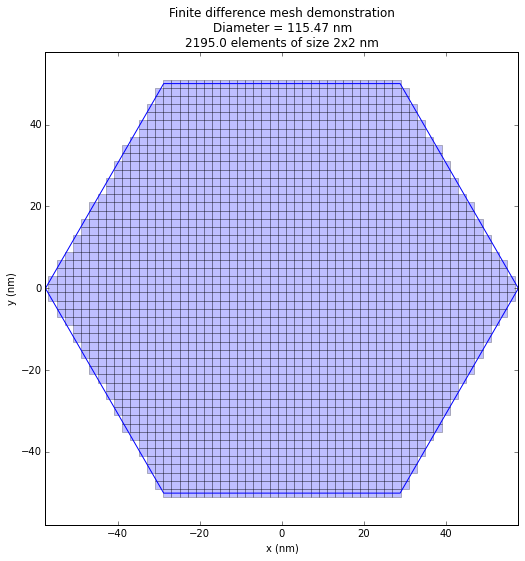

In [40]:
plot_poly_fidi_mesh(diameter=2*find_circumradius(6,apothem=50),n=6,x_spacing=2,y_spacing=2)